# CSC420 Final Project

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
from sympy import symbols, solve
import numpy as np
import random

## Panorama Stitching

To do panorama stitching, we need to:

1. Match points between pairs of images I and J
2. Compute a transformation between the between matches in I and J : a homography
3. Do it robustly (RANSAC)
4. Warp the first image to the second using the estimated homography

(480, 479)
(480, 479)


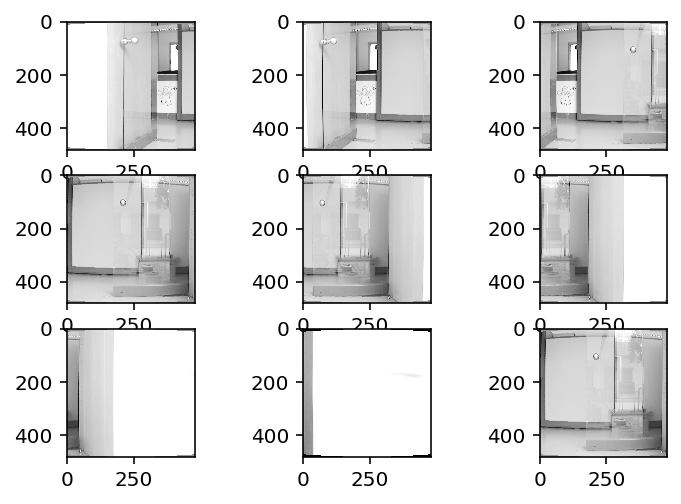

In [94]:
# Pano dataset Source: http://www.iiia.csic.es/~aramisa/datasets/iiiapanos.html
# Facial Recognition Dataset Source: Aligned Face Dataset For Face Recognition: https://www.kaggle.com/frules11/pins-face-recognition/data

img1 = cv2.imread("cyl_image04.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("cyl_image05.png", cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("cyl_image06.png", cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread("cyl_image07.png", cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread("cyl_image08.png", cv2.IMREAD_GRAYSCALE)
img6 = cv2.imread("cyl_image09.png", cv2.IMREAD_GRAYSCALE)
img7 = cv2.imread("cyl_image10.png", cv2.IMREAD_GRAYSCALE)
img8 = cv2.imread("cyl_image11.png", cv2.IMREAD_GRAYSCALE)

# img_lst = [img1, img2, img3, img4, img5, img6, img7, img8]
img_lst = [img1, img2, img3, img4]
print(img1.shape)
print(img2.shape)
# print(img4.shape)

f, ax = plt.subplots(nrows=3, ncols=3)
ax[0, 0].imshow(img1, cmap="gray")
ax[0, 1].imshow(img2, cmap="gray")
ax[0, 2].imshow(img3, cmap="gray")
ax[1, 0].imshow(img4, cmap="gray")
ax[1, 1].imshow(img5, cmap="gray")
ax[1, 2].imshow(img6, cmap="gray")
ax[2, 0].imshow(img7, cmap="gray")
ax[2, 1].imshow(img8, cmap="gray")

plt.imshow(img4, cmap="gray")


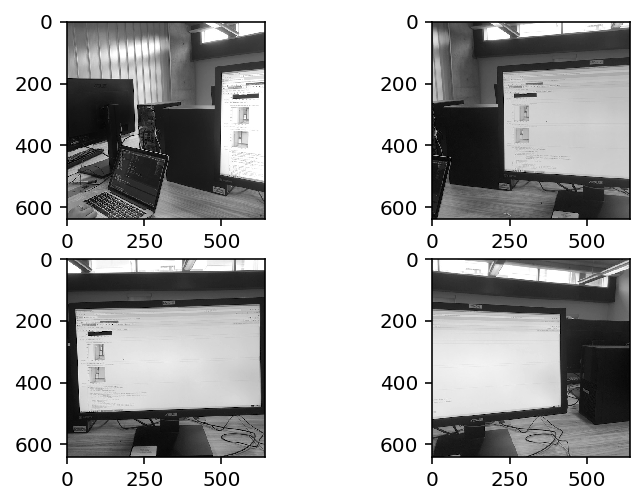

In [86]:
img1 = cv2.imread("1.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("2.jpg", cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("3.jpg", cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread("4.jpg", cv2.IMREAD_GRAYSCALE)

f, ax = plt.subplots(nrows=2, ncols=2)
ax[0, 0].imshow(img1, cmap="gray")
ax[0, 1].imshow(img2, cmap="gray")
ax[1, 0].imshow(img3, cmap="gray")
ax[1, 1].imshow(img4, cmap="gray")

In [1]:
def feature_map(img1, img2):

    sift = cv2.xfeatures2d.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)


    match = cv2.BFMatcher()
    matches = match.knnMatch(des1,des2,k=2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x[0].distance)
    print(f"there are {len(matches)} matches")
#     orb.clear()

    good = []
    for m,n in matches:
      good.append(m)
    return kp1, kp2, good

In [3]:
def compute_H_wrong(kp1_sample, kp2_sample):
    # Matrix A
    A = np.zeros((2 * 4, 9))
    for i in range(len(kp1_sample)):
        x, y = kp1_sample[i]
        x_p, y_p = kp2_sample[i]
        A[2 * i] = np.array([x, y, 1, 0, 0, 0, -x_p * x, -x_p * y, -x_p])
        A[2 * i + 1] = np.array([0, 0, 0, x, y, 1, -y_p * x, -y_p * y, -y_p])

    # svd approach
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    h_unit = vh[-1, :]
    H = h_unit.reshape((3, 3))

#     homogeneous_orig = np.append(orig, np.ones((orig.shape[0],1)), axis=1)
#     print(np.sum(np.dot(A,h_unit)))

    return H

In [3]:
def compute_H(orgs, trans):
    try:
      org1, org2, org3, org4 = orgs[:]
      trans1, trans2, trans3, trans4 = trans[:]
    except Exception:
      print(orgs, trans)

    org1, org2, org3, org4 = org1[0], org2[0], org3[0], org4[0]
    trans1, trans2, trans3, trans4 = trans1[0], trans2[0], trans3[0], trans4[0]

    a = symbols('a')
    b = symbols('b')
    c = symbols('c')
    d = symbols('d')
    e = symbols('e')
    f = symbols('f')
    h = symbols('h')
    k = symbols('k')

    expr1 = a*org1[0] + b*org1[1] + c - trans1[0] * (h*org1[0] + k*org1[1] + 1)
    expr2 = d*org1[0] + e*org1[1] + f - trans1[1] * (h*org1[0] + k*org1[1] + 1)

    expr3 = a*org2[0] + b*org2[1] + c - trans2[0] * (h*org2[0] + k*org2[1] + 1)
    expr4 = d*org2[0] + e*org2[1] + f - trans2[1] * (h*org2[0] + k*org2[1] + 1)

    expr5 = a*org3[0] + b*org3[1] + c - trans3[0] * (h*org3[0] + k*org3[1] + 1)
    expr6 = d*org3[0] + e*org3[1] + f - trans3[1] * (h*org3[0] + k*org3[1] + 1)

    expr7 = a*org4[0] + b*org4[1] + c - trans4[0] * (h*org4[0] + k*org4[1] + 1)
    expr8 = d*org4[0] + e*org4[1] + f - trans4[1] * (h*org4[0] + k*org4[1] + 1)

    sol = solve([expr1, expr2, expr3, expr4, expr5, expr6, expr7, expr8])

    try:
#         print(sol)
        H = np.array([[sol[a], sol[b], sol[c]], [sol[d], sol[e], sol[f]], [sol[h], sol[k], 1]])
    except KeyError:
        print("ERROR CALCULATING H")
        print(sol)
        print(orgs)
        print(trans)
        print(a, b, c, d, e, f, h, k)

    return H

In [4]:
def ransac(kp1_coords, kp2_coords):
    highest_num_inliers = 0
    best_H = None
    best_pt = None
    
    # fit threshold
    epsilon = 2
    
    # Assume there are at least 50% inliers, so p = 0.5
    # each random sample takes 4 items, so k = 4
    # we want the success prob to be at least 90%, so P = 0.9
    # Then 1 - P = (1 - p^k)^S, where S is min num of trials
    # 0.1 = (0.9375)^S
    # S = 36
    s = 36
    
    for i in range(s):
        #randonly select 4 kp pairs to compute H
        num_inliers = 0
        
#         kp1_batch = random.sample(kp1_coords, k=4)
#         kp2_batch = random.sample(kp2_coords, k=4)
        idx_list = random.sample(range(0, len(kp1_coords)), 4)
        kp1_batch = np.array([kp1_coords[i] for i in idx_list], dtype=np.float64)
        kp2_batch = np.array([kp2_coords[i] for i in idx_list], dtype=np.float64)

        H = compute_H(kp1_batch, kp2_batch)
        

        #count inliers
        for j in range(len(kp1_coords)):
            
            kp1 = np.array(kp1_coords[j][0])
            kp2 = np.array(kp2_coords[j][0])
            
            pt = np.ones((3, 1))
            pt[0, 0] = kp1[0]
            pt[1, 0] = kp1[1]
            pt = np.matmul(H, pt)

            pt[0, 0] = pt[0, 0]/pt[2, 0]
            pt[1, 0] = pt[1, 0]/pt[2, 0]
            pt[2, 0] = pt[2, 0]/pt[2, 0]
            
            p_prime = [int(pt[0, 0]), int(pt[1, 0])]
            # count num of ||p', Hp|| < epsilon
            # This works because Euclidean distance is l2 norm and the default value of ord parameter in numpy.linalg.norm is 2.
            dist = np.linalg.norm(p_prime - kp2)
            
            if dist < epsilon:
                num_inliers += 1
                
        if num_inliers > highest_num_inliers:
            highest_num_inliers = num_inliers
            best_H = H
            best_pt = p_prime
    
    print("highest_num_inliers: {}".format(highest_num_inliers))
    return best_H, best_pt


In [5]:
def transform_with_same_homography(img1, img2):
    print(f"transforming img1 {img1.shape}, img2 {img2.shape}")
    # Match feature points
    kp1, kp2, good = feature_map(img1, img2)




    kp1_coords = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    kp2_coords = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)



    H, pt = ransac(kp1_coords, kp2_coords)

#     img3 = np.zeros(img1.shape)
#     min_x = 0
#     min_y = 0

    img3 = np.zeros((img1.shape[0]+400, img1.shape[1]*3))

    orig_row = 200
    orig_col = img1.shape[1]

    for row_idx in range(img1.shape[0]):
        for col_idx in range(img1.shape[1]):
            curr_mat = np.ones((3, 1))
            curr_mat[0, 0] = row_idx
            curr_mat[1, 0] = col_idx

            curr_out = np.matmul(H, curr_mat)
            x = curr_out[0, 0] / curr_out[2, 0]
            y = curr_out[1, 0] / curr_out[2, 0]

            x += orig_row
            y += orig_col
            
            if 0 <= int(x) < img3.shape[0] and 0 <= int(y) < img3.shape[1]:
                img3[int(x), int(y)] = img1[row_idx, col_idx]

    return img3, pt


transforming img1 (480, 479), img2 (480, 479)
there are 171 matches


highest_num_inliers: 60


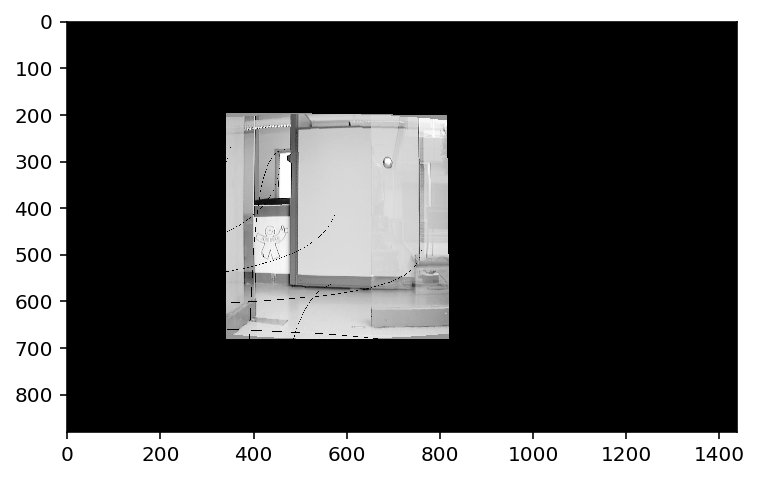

In [104]:
img_out, pt= transform_with_same_homography(img3, img4)
# img_out = cv2.GaussianBlur(img_out,(5,5),0)

plt.imshow(img_out, cmap="gray")

# f, ax = plt.subplots(nrows=1, ncols=3)
# ax[0].imshow(img1, cmap="gray")
# ax[1].imshow(img2, cmap="gray")
# ax[2].imshow(img_out, cmap="gray")

In [92]:
cv2.imwrite("own_img.jpg", img_out)

True

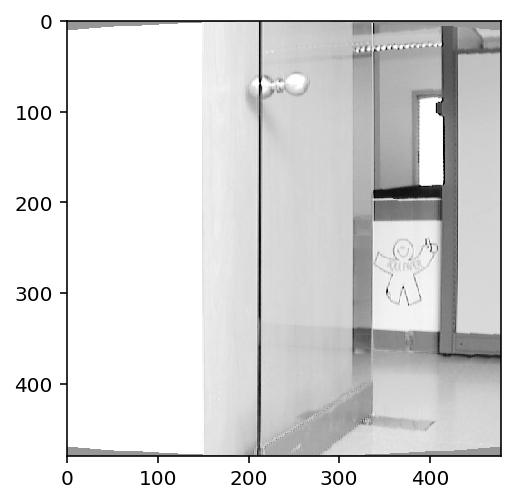

In [94]:
plt.imshow(img1, cmap="gray")


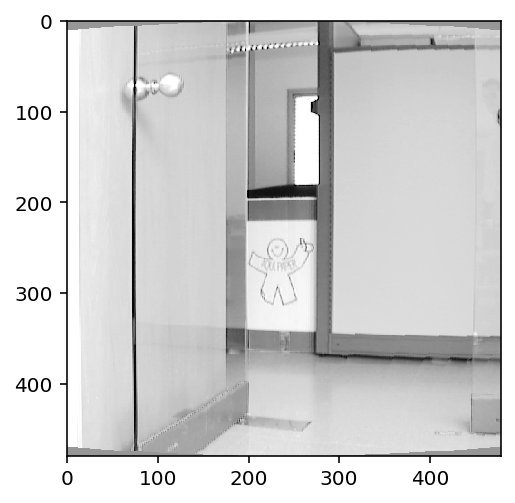

In [97]:
plt.imshow(img2, cmap="gray")

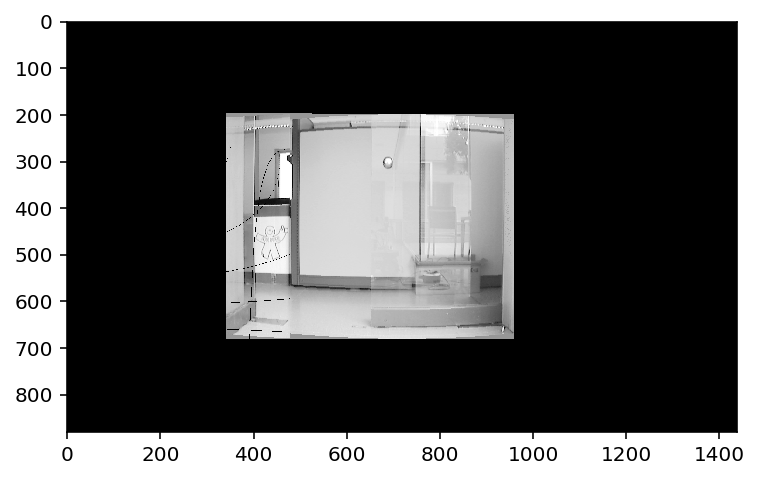

In [105]:
img_stitched = stitch(img4, img_out, pt)
plt.imshow(img_stitched, cmap="gray")

In [107]:
cv2.imwrite("img3_4.jpg", img_out)

True

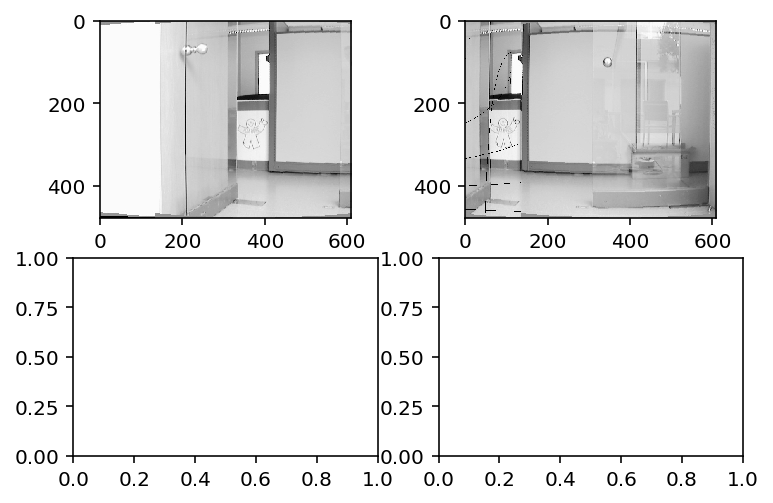

In [9]:
new1_2 = cv2.imread("new1_2.jpg", cv2.IMREAD_GRAYSCALE)
new3_4 = cv2.imread("new3_4.jpg", cv2.IMREAD_GRAYSCALE)

f, ax = plt.subplots(nrows=2, ncols=2)
ax[0, 0].imshow(new1_2, cmap="gray")
ax[0, 1].imshow(new3_4, cmap="gray")

transforming img1 (480, 610), img2 (480, 610)
there are 181 matches


highest_num_inliers: 31


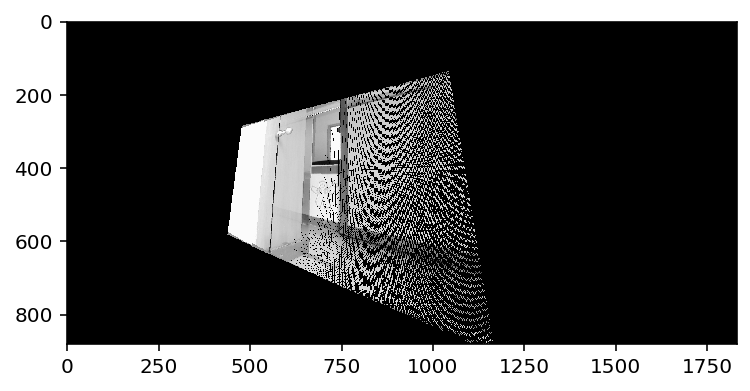

In [20]:
n_img_out, pt= transform_with_same_homography(new1_2, new3_4)
# img_out = cv2.GaussianBlur(img_out,(5,5),0)

plt.imshow(n_img_out, cmap="gray")

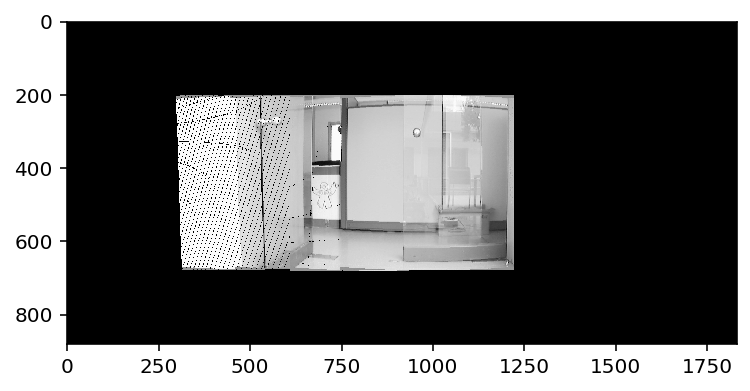

In [11]:
img_stitched = stitch(new3_4, n_img_out, pt)
plt.imshow(img_stitched, cmap="gray")

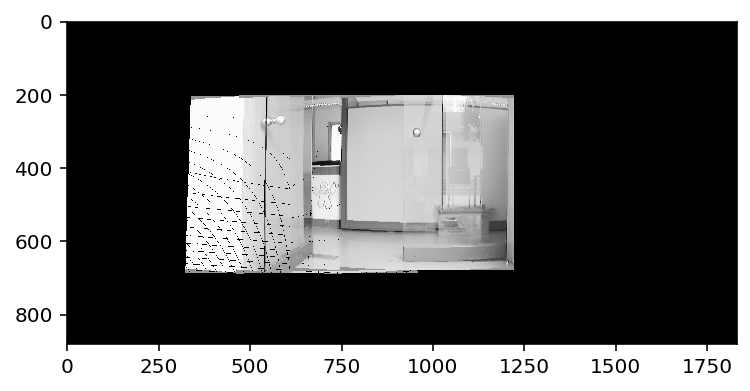

In [136]:
img_stitched = stitch(new3_4, n_img_out, pt)
plt.imshow(img_stitched, cmap="gray")

In [137]:
cv2.imwrite("123.jpg", img_stitched)

True

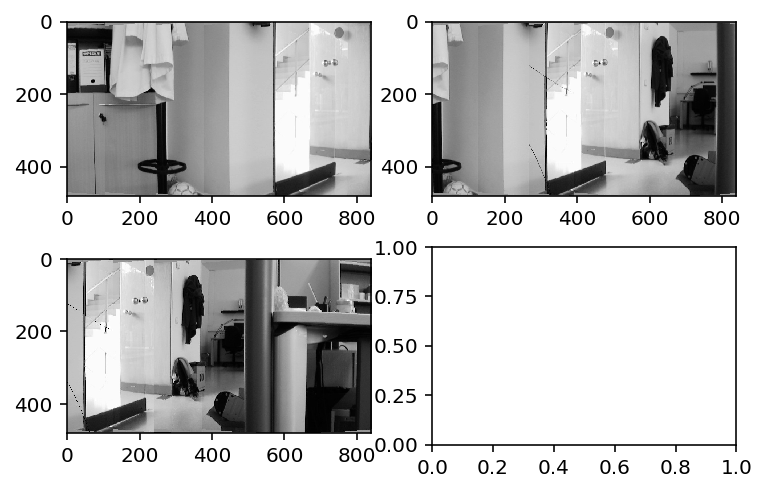

In [7]:
img1 = cv2.imread("1234.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("3456.jpg", cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("5678.jpg", cv2.IMREAD_GRAYSCALE)


f, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].imshow(img1, cmap="gray")
ax[0, 1].imshow(img2, cmap="gray")
ax[1, 0].imshow(img3, cmap="gray")



In [17]:
cv2.imwrite("pano1_bw.png", img1)
cv2.imwrite("pano2_bw.png", img2)
cv2.imwrite("pano3_bw.png", img3)
cv2.imwrite("pano4_bw.png", img4)
cv2.imwrite("pano5_bw.png", img5)
cv2.imwrite("pano6_bw.png", img6)
cv2.imwrite("pano7_bw.png", img7)
cv2.imwrite("pano8_bw.png", img8)

True

(480, 479)
(480, 479)


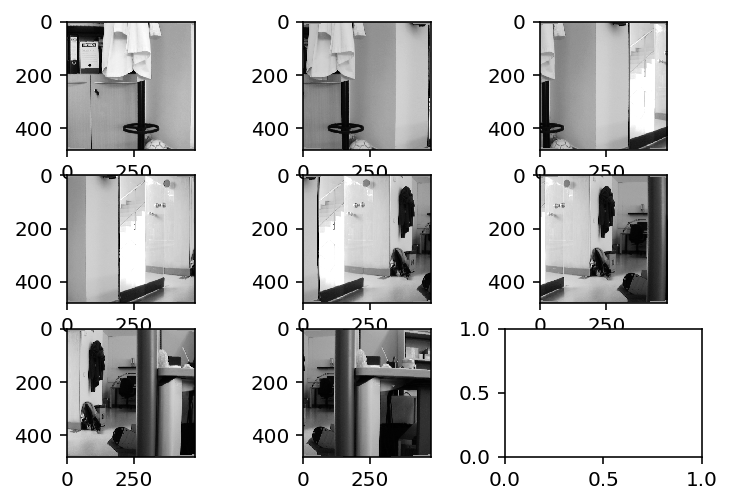

In [15]:
img1 = cv2.imread("pano1.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("pano2.png", cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("pano3.png", cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread("pano4.png", cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread("pano5.png", cv2.IMREAD_GRAYSCALE)
img6 = cv2.imread("pano6.png", cv2.IMREAD_GRAYSCALE)
img7 = cv2.imread("pano7.png", cv2.IMREAD_GRAYSCALE)
img8 = cv2.imread("pano8.png", cv2.IMREAD_GRAYSCALE)

# img_lst = [img1, img2, img3, img4, img5, img6, img7, img8]
img_lst = [img1, img2, img3, img4]
print(img1.shape)
print(img2.shape)
# print(img4.shape)

f, ax = plt.subplots(nrows=3, ncols=3)
ax[0, 0].imshow(img1, cmap="gray")
ax[0, 1].imshow(img2, cmap="gray")
ax[0, 2].imshow(img3, cmap="gray")
ax[1, 0].imshow(img4, cmap="gray")
ax[1, 1].imshow(img5, cmap="gray")
ax[1, 2].imshow(img6, cmap="gray")
ax[2, 0].imshow(img7, cmap="gray")
ax[2, 1].imshow(img8, cmap="gray")

transforming img1 (480, 840), img2 (480, 840)
there are 133 matches


highest_num_inliers: 12


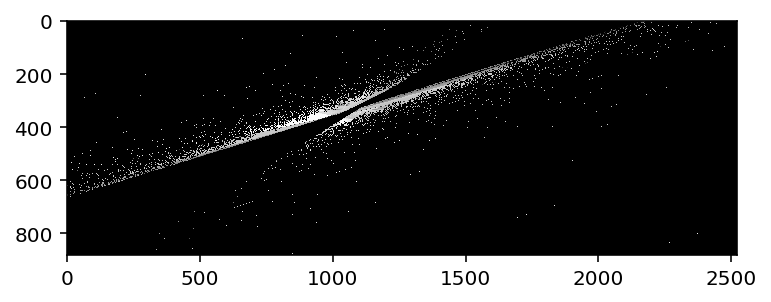

In [14]:
img_out, pt= transform_with_same_homography(img1, img3)
# img_out = cv2.GaussianBlur(img_out,(5,5),0)

plt.imshow(img_out, cmap="gray")

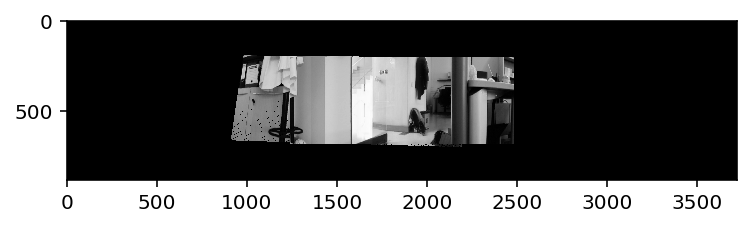

In [28]:
img_stitched = stitch(img2, img_out, pt)
plt.imshow(img_stitched, cmap="gray")

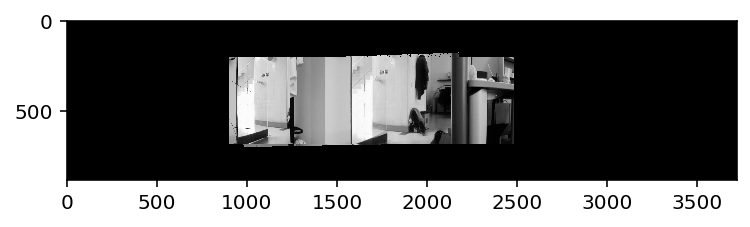

In [26]:
img_stitched_test = stitch(img2, img_out, pt)
plt.imshow(img_stitched_test, cmap="gray")

In [30]:
cv2.imwrite("n1234567888.jpg", img_stitched)

True

In [292]:
# Test Version
def transform_with_same_homography_test(img1, img2):
    print(f"transforming img1 {img1.shape}, img2 {img2.shape}")
    # Match feature points
    kp1, kp2, matches = feature_map(img1, img2)

    # put matched coords into lists of [(x, y)]s
    kp1_coords = np.array([list((kp1[mat.queryIdx].pt[1], kp1[mat.queryIdx].pt[0])) for mat in matches],
                          dtype=np.int)
    kp2_coords = np.array([list((kp2[mat.trainIdx].pt[1], kp2[mat.trainIdx].pt[0])) for mat in matches],
                          dtype = np.int)

    # randomly generate 4 keypoints from each kp list
#     idx_list = matches[:4]
#     idx_list = [0, 1, 2, 3]
#     idx_list = random.sample(range(0, 20), 4)
#     kp1_sample = np.array([kp1_coords[i] for i in idx_list], dtype=np.float64)
#     kp2_sample = np.array([kp2_coords[i] for i in idx_list], dtype=np.float64)
    # ========== Generate sample ==========
    kp1_sample = []
    kp2_sample = []
    pick_idx = 0
    pick = True
    while len(kp1_sample) < 4:
        kp1_qualify = kp2_qualify = True
        curr_p1 = kp1_coords[pick_idx]
        curr_p2 = kp2_coords[pick_idx]
        for p1 in kp1_sample:
            if abs(p1[0] - curr_p1[0]) < 3 and abs(p1[1] - curr_p1[1]) < 3:
                kp1_qualify = False
        for p2 in kp2_sample:
            if abs(p2[0] - curr_p2[0]) < 3 and abs(p2[1] - curr_p2[1]) < 3:
                kp2_qualify = False
        if kp1_qualify and kp2_qualify:
            kp1_sample.append(curr_p1)
            kp2_sample.append(curr_p2)
        else:
            print(f"skipping points {curr_p1}, {curr_p2}")
        pick_idx += 1


    # TODO: RANSAC: this could contain outliers.
    H = compute_H(kp1_sample, kp2_sample)


    top_left = np.array([1, 1, 1])
    top_left = np.matmul(H, top_left).astype(np.float)
    top_left = np.array([top_left[0] / top_left[2], top_left[1] / top_left[2]]).astype(np.int)

    bottom_left = np.array([img1.shape[0], 1, 1])
    bottom_left = np.matmul(H, bottom_left).astype(np.float)
    bottom_left = np.array([bottom_left[0] / bottom_left[2], bottom_left[1] / bottom_left[2]]).astype(np.int)

    top_right = np.array([1, img1.shape[1], 1])
    top_right = np.matmul(H, top_right).astype(np.float)
    top_right = np.array([top_right[0] / top_right[2], top_right[1] / top_right[2]]).astype(np.int)

    bottom_right = np.array([img1.shape[0], img1.shape[1], 1])
    bottom_right = np.matmul(H, bottom_right).astype(np.float)
    bottom_right = np.array([bottom_right[0] / bottom_right[2], bottom_right[1] / bottom_right[2]]).astype(np.int)

    x_offset = abs(np.min([0, top_left[0], top_right[0]]))
    y_offset = abs(np.min([0, top_left[1], bottom_left[1]]))

    top_left[0] += x_offset
    top_left[1] += y_offset
    top_right[0] += x_offset
    top_right[1] += y_offset
    bottom_left[0] += x_offset
    bottom_left[1] += y_offset
    bottom_right[0] += x_offset
    bottom_right[1] += y_offset

    bound_top_left = np.array([0, 0])
    bound_top_left[0] = max(top_left[0], top_right[0])
    bound_top_left[1] = max(top_left[1], bottom_left[1])
    bound_top_left = bound_top_left.astype(np.int)

    bound_bottom_right = np.array([0, 0])
    bound_bottom_right[0] = min(bottom_right[0], bottom_left[0])
    bound_bottom_right[1] = min(bottom_right[1], top_right[1])
    bound_bottom_right = bound_bottom_right.astype(np.int)
    print(bound_top_left)
    print(bound_bottom_right)

    final_shape = tuple(bound_bottom_right - bound_top_left)
    img_out = np.zeros(final_shape)
    for row_idx in range(img1.shape[0]):
        for col_idx in range(img1.shape[1]):
            curr_mat = np.array([row_idx, col_idx, 1])

            curr_out = np.matmul(H, curr_mat)
            x = curr_out[0] / curr_out[2]
            y = curr_out[1] / curr_out[2]

            x += x_offset
            y += y_offset
            curr_idx = np.array([int(x), int(y)])
            if 0 < curr_idx[0] < final_shape[0] and 0 < curr_idx[1] < final_shape[1]:
                img_out[curr_idx[0], curr_idx[1]] = img1[row_idx, col_idx]
    return img_out

In [293]:
def stitch_test(img, trans):
    kp1, kp2, matches = feature_map(img, trans)

    # put matched coords into lists of [(x, y)]s
    kp1 = list((kp1[matches[0].queryIdx].pt[1], kp1[matches[0].queryIdx].pt[0]))
    kp2 = list((kp2[matches[0].trainIdx].pt[1], kp2[matches[0].trainIdx].pt[0]))
    print(kp1)
    print(kp2)
    x_diff = int(kp1[0] - kp2[0])
    y_diff = int(kp1[1] - kp2[1])
    print(y_diff)
    new_img = np.zeros((min(img.shape[0], trans.shape[0]), trans.shape[1] + y_diff))
    new_img[:trans.shape[0], :trans.shape[1]] = trans
#     return new_img
    for row in range(new_img.shape[0]):
        for col in range(y_diff, new_img.shape[1]):
            new_img[row, col] = img[row, col - y_diff]
    return new_img

In [304]:
img1_transformed = transform_with_same_homography_test(img1, img2)
# f, ax = plt.subplots(nrows=1, ncols=3)
# ax[0].imshow(img1, cmap="gray")
# ax[1].imshow(img2, cmap="gray")
# ax[2].imshow(img1_transformed, cmap="gray")
print(img2.shape)
print(img1_transformed.shape)
img1_reshape = cv2.resize(img1_transformed, img2.shape)
print(img2.shape)
print(img1_reshape.shape)
img12 = stitch_test(img2, img1_transformed)
plt.imshow(img12, cmap="gray")


transforming img1 (480, 479), img2 (480, 479)
there are 286 matches
[3 6]
[480 477]


(480, 479)
(477, 471)


error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [273]:
# TEST
img3_transformed = transform_with_same_homography_test(img3, img4)
# f, ax = plt.subplots(nrows=1, ncols=3)
# ax[0].imshow(img3, cmap="gray")
# ax[1].imshow(img4, cmap="gray")
# ax[2].imshow(imgimg3_transformed_out, cmap="gray")
print(img4.shape)
print(img3_transformed.shape)
img34 = stitch_test(img4, img3_transformed)
plt.imshow(img34, cmap="gray")

transforming img1 (480, 479), img2 (480, 479)
there are 171 matches
skipping points [373 288], [373 151]
skipping points [373 303], [373 164]
[22  3]
[493 482]


(480, 479)
(471, 479)


error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


(477, 610)
(480, 479)


error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


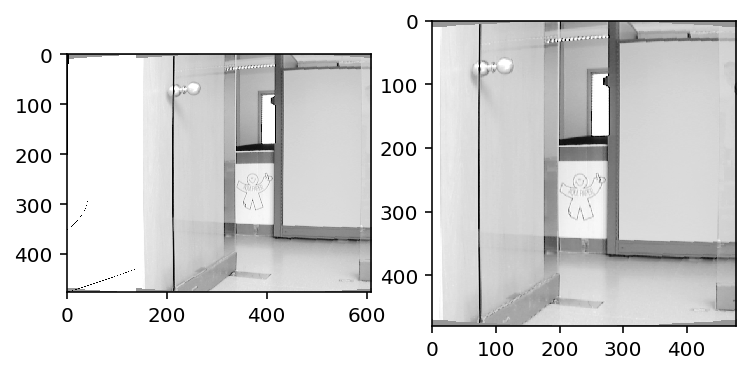

In [268]:
# print(img12.shape)
# print(img34.shape)
# img34_crop = cv2.resize(img34, (img12.shape[1], img12.shape[0]), interpolation=cv2.INTER_LINEAR)
# img12_crop = img12
# img12_crop = img12[20:img12.shape[0] - 20, 20: img12.shape[1] - 20]
# img34_crop = img34[20:img34.shape[0] - 20, 20: img34.shape[1] - 20]
# print(img12_crop.shape)
# print(img34_crop.shape)

# f, ax = plt.subplots(nrows=2, ncols=2)
# ax[0, 0].imshow(img12, cmap="gray")
# ax[0, 1].imshow(img34, cmap="gray")
# ax[1, 0].imshow(img12_crop, cmap="gray")
# ax[1, 1].imshow(img34_crop, cmap="gray")

print(img12.shape)
print(img2.shape)
f, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img12, cmap="gray")
ax[1].imshow(img2, cmap="gray")
k1, k2, m = feature_map(img12_crop, img2)

In [6]:
def stitch(img, trans, trans_pt):
#     new_img = cv2.copyMakeBorder(img,100,100,img.shape[1],img.shape[1],cv2.BORDER_CONSTANT)
    new_img = trans
    img_padded = cv2.copyMakeBorder(img,200,200,img.shape[1],img.shape[1],cv2.BORDER_CONSTANT)
#     plt.imshow(img_padded, cmap="gray")
    trans_x, trans_y = trans_pt[:]
    img_x, img_y = trans_x, trans_y

    for row in range(img_padded.shape[0]):
        for col in range(img_padded.shape[1]):

            if img_padded[row, col] > 0:
                virtical = img_x - row
                hori = img_y - col
                try:
                    new_img[trans_x - virtical, trans_y - hori] = img_padded[row, col]
                except IndexError:
                    print([trans_x, trans_y, virtical, hori])
    return new_img

[306, 252]


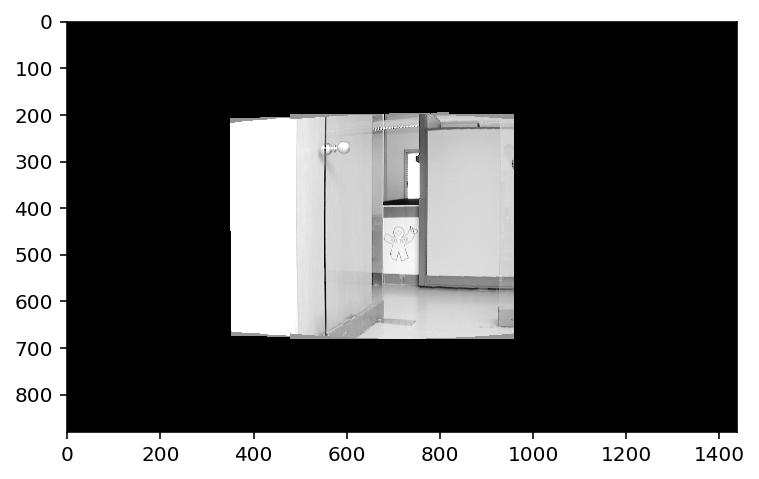

In [109]:
print(pt)
pt = [int(pt[0]), int(pt[1])]
img_stitched = stitch(img2, img_out, pt)
plt.imshow(img_stitched, cmap="gray")

In [0]:
def stitch_mutiple(img_lst):
    if len(img_lst) < 2:
        print("invalid length")
    if len(img_lst) == 2:
        return final_stitch(img_lst[0], img_lst[1])
    else:
        h_length = int(len(img_lst)/2)  # length 2^n

        return final_stitch(stitch_mutiple(img_lst[:h_length]), stitch_mutiple(img_lst[h_length:]))


In [0]:
def final_stitch(img1, img2):
    img_out, pt = transform_with_same_homography(img1, img2)
    pt = [int(pt[0]), int(pt[1])]
    img_stitched = stitch(img2, img_out, pt)
    return img_stitched

In [27]:
stitched = stitch_mutiple(img_lst)
plt.imshow(stitched, cmap="gray")

transforming img1 (480, 479), img2 (480, 479)
there are 286 matches
{a: 658554291/671283346, b: 541280/335641673, c: 559253930/335641673, d: -4322479/671283346, e: 331148273/335641673, f: -45237056229/335641673, h: -21721/671283346, k: -1511/335641673}


transforming img1 (480, 479), img2 (480, 479)
there are 171 matches
skipping points [373 288], [373 151]
skipping points [373 303], [373 164]
{a: 810120009/786346753, b: 38440634/786346753, c: -12530969316/786346753, d: -835084/786346753, e: 823210191/786346753, f: -115037339659/786346753, h: -26332/786346753, k: 103058/786346753}


transforming img1 (880, 1437), img2 (880, 1437)


error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


transforming img1 (480, 479), img2 (480, 479)
there are 286 matches


(880, 1437)


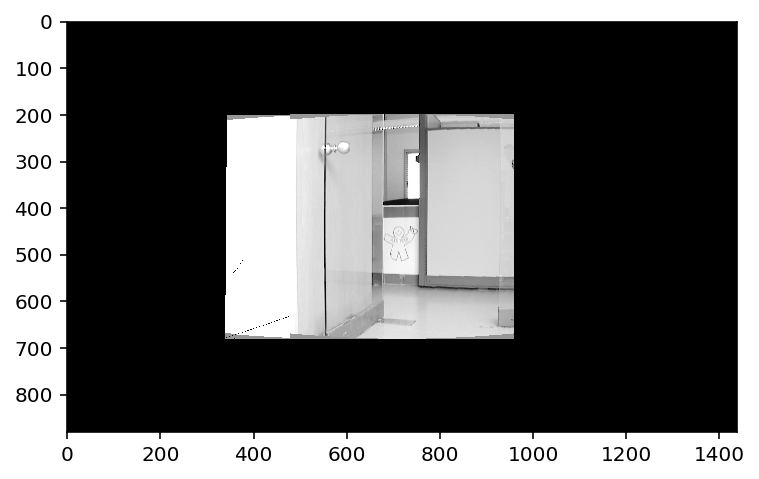

In [305]:
img12 = final_stitch(img1, img2)
print(img12.shape)
plt.imshow(img12, cmap="gray")

transforming img1 (480, 479), img2 (480, 479)
there are 171 matches
skipping points [373 288], [373 151]
skipping points [373 303], [373 164]


(880, 1437)


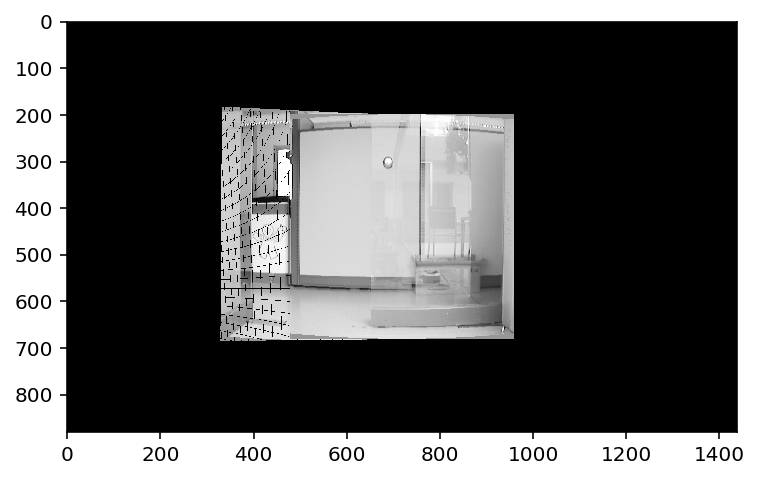

In [306]:
img34 = final_stitch(img3, img4)
print(img34.shape)
plt.imshow(img34, cmap="gray")

In [307]:
def crop_image_only_outside(img,tol=0):
    # img is 2D or 3D image data
    # tol  is tolerance
    mask = img>tol
    if img.ndim==3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    return img[row_start:row_end,col_start:col_end]

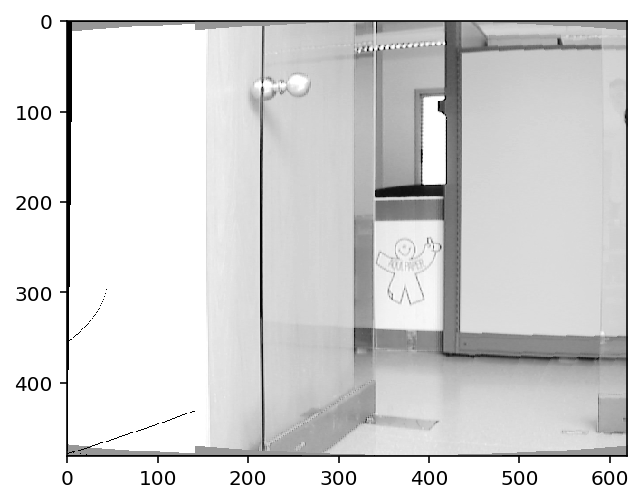

In [308]:
img12_c = crop_image_only_outside(img12).astype('uint8')

plt.imshow(img12_c, cmap="gray")

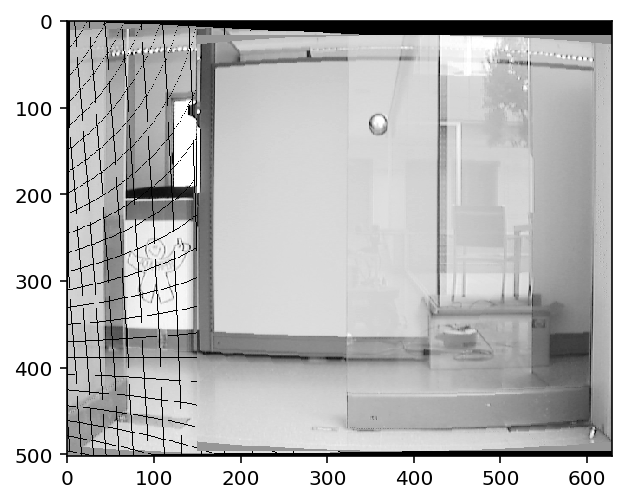

In [309]:
img34_c = crop_image_only_outside(img34).astype('uint8')

plt.imshow(img34_c, cmap="gray")

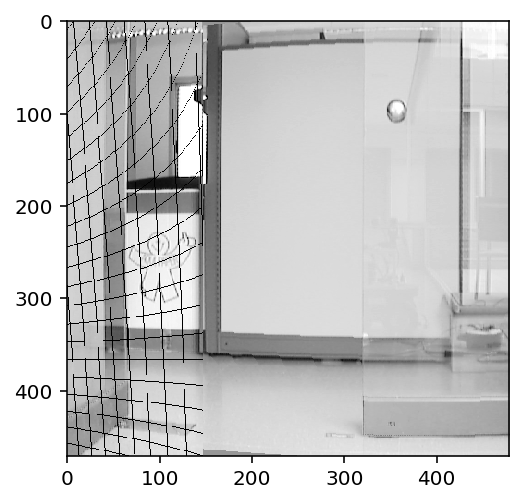

In [274]:
img_34_altered = img34_c[22:493, 3:482]
plt.imshow(img_34_altered, cmap="gray")

In [280]:
print(img12_c.shape, img34_c.shape)

k1, k2, m = feature_map(img12_c, img34_c)

(481, 620) (502, 629)
there are 145 matches


transforming img1 (481, 620), img2 (502, 629)
there are 145 matches
skipping points [177 393], [186 124]
skipping points [180 394], [190 125]


(881, 1860)


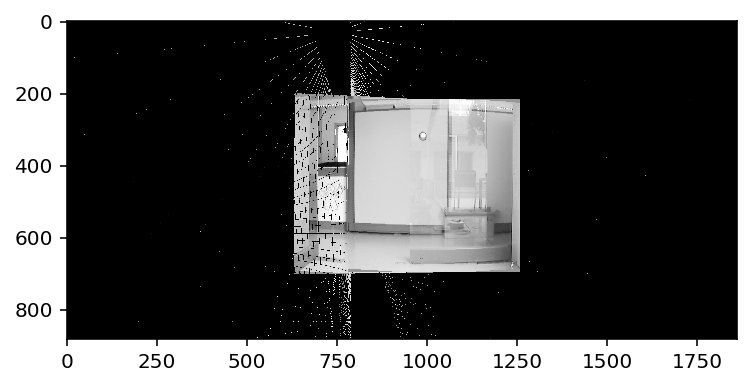

In [310]:
img1234 = final_stitch(img12_c, img34_c)
print(img1234.shape)
plt.imshow(img1234, cmap="gray")

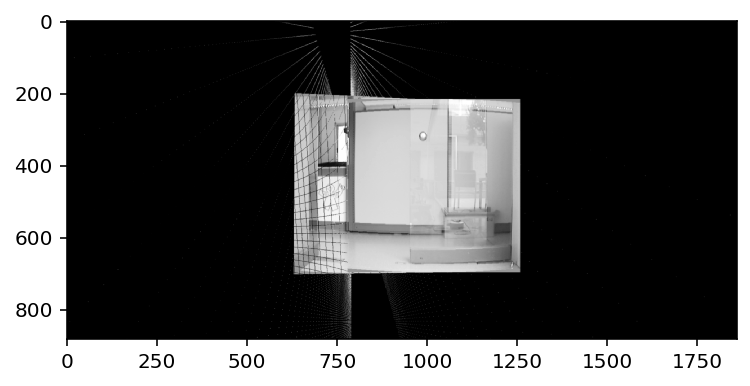

In [311]:
img1234_gau = cv2.GaussianBlur(img1234, (5, 5), 0)
plt.imshow(img1234_gau, cmap="gray")

In [221]:
def length(lst):
    i = 0
    found_i = False
    found_j = False
    
    while lst[i] == 0 and found_i == False:
        i += 1
        if i >= len(lst):
            return 0
        if lst[i] != 0:
            found_i = True

    j = -1
    while lst[j] == 0 and found_j == False:
        j -= 1
        if -j > len(lst):
            return 0
        
        if lst[j] != 0:
            found_j = True
    
    return len(lst) + j + 1 - i
    

In [222]:
a = [0, 0, 0]
print(length(a))

0


In [248]:
def resizing(img, zuos, zuox, yous, youx):
    if yous[1] > youx[1]:
        
        result_youx = youx
        
        lst = img[:, youx[1]]
        i = 0
        l = length(lst)
        
        result_yous = (youx[0] - l, youx[1])
    else:
        
        result_yous = yous
        
        lst = img[:, yous[1]]
        i = 0
        l = length(lst)
        
        result_youx = (yous[0] + l, yous[1])
        
    if zuos[1] > zuox[1]:
        result_zuos = (result_yous[0], zuos[1])
        
        return img[result_yous[0]:result_youx[0]+1, result_zuos[1]:result_youx[1] + 1]
    else:
        retult_zuox = (result_youx[0], zuox[1])
        
        return img[result_yous[0]:result_youx[0]+1, result_yous[1]:result_zuox[1] + 1]



In [0]:
def find_vertex(img):
    
    row, col= img.shape[0], img.shape[1]
    
    up = (row, col)
    down = (0, 0)
    left = (0, col)
    right = 
    
    for i in range(row):
        for j in range(col):
            if img[i, j] > 0:
                if 
                upper_bound = min(upper_bound, j)
         

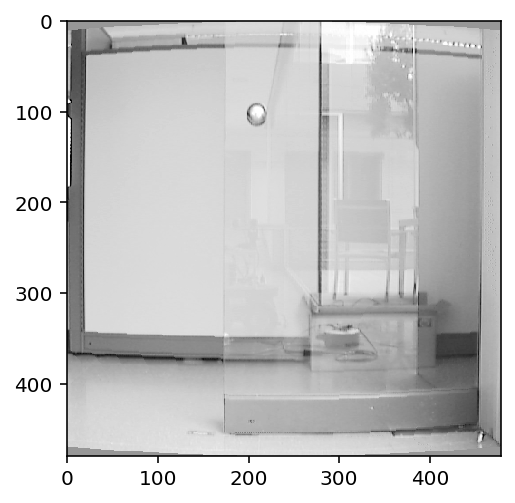

In [42]:
plt.imshow(img4, cmap="gray")

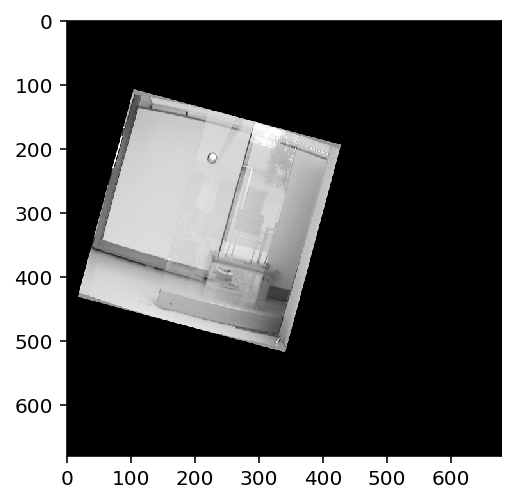

In [249]:
img_p = cv2.copyMakeBorder(img4,100,100,100,100,cv2.BORDER_CONSTANT)
rows, cols = img_p.shape
M = cv2.getRotationMatrix2D((100, 120), -15, .7)
dst = cv2.warpAffine(img_p, M, (cols,rows))

plt.imshow(dst, cmap="gray")

0


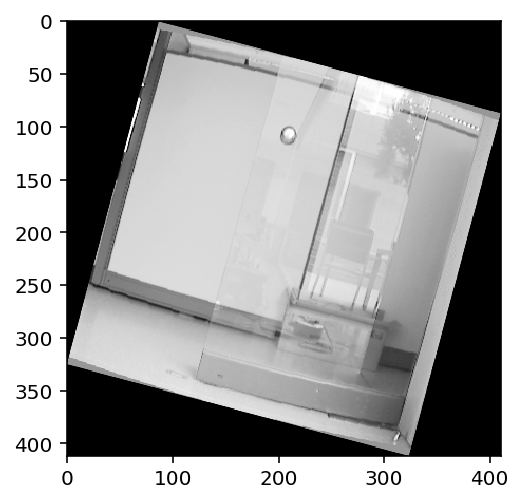

In [250]:
img44 = crop_image_only_outside(dst)
print(dst[0, 0])
plt.imshow(img44, cmap="gray")

In [252]:
zuos = (50, 100)
zuox = (300, 50)
yous = (100, 400)
youx = (370, 320)
print(img44[zuos[0], zuos[1]], img44[zuox[0], zuox[1]], img44[yous[0], yous[1]], img44[youx[0], youx[1]])

192 210 184 139


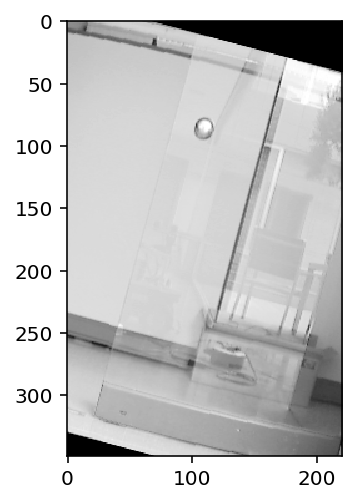

In [253]:
imgg = resizing(img44, zuos, zuox, yous, youx)
plt.imshow(imgg, cmap="gray")

In [172]:
k1, k2, m = feature_map(imgg, img3)

there are 138 matches
